In [263]:
from IPython.display import Image, display
from itertools import groupby
from pathlib import Path
import re
import requests


import rdkit
from rdkit import Chem  # DOC: https://www.rdkit.org/docs/GettingStartedInPython.html
from rdkit.Chem import AllChem  #DOC: https://www.rdkit.org/docs/source/rdkit.Chem.AllChem.html 
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
from rdkit.Chem.AtomPairs import Pairs

# When this function is enabled, RDKit attempts to assign 2D coordinates to the atoms of the molecule before drawing them. 
# This can be useful for obtaining visually pleasing 2D representations of molecules, 
# especially when the molecules do not have pre-defined 2D coordinates.
# https://rdkit.org/docs/source/rdkit.Chem.rdDepictor.html#rdkit.Chem.rdDepictor.SetPreferCoordGen 
rdDepictor.SetPreferCoordGen(True)


import zipfile
import os


In [223]:
# https://greglandrum.github.io/rdkit-blog/posts/2022-10-28-dealing-with-multiconformer-sd-files.html
# http://rdkit.org/docs/source/rdkit.Chem.PandasTools.html 


# Download the data, if it don't already exist

In [272]:
def download_zipfile(url: str, save_as: str):
    """Download a zip file from the specified URL and save it to the specified location.

    Parameters
    ----------
        url : str
            The URL of the zip file to download.
        save_as : str
            The filename (including the path) to save the downloaded zip file as.
    """
    request = requests.get(url)
    open(save_as, "wb").write(request.content)
    print(f"Downloaded file from '{url}' and saved as '{os.getcwd()}/{save_as}'")


def unzip_file(zip_file_path: str, extract_to: str):
    """Extract the contents of a zip file to the specified directory.

    Parameters
    ----------
        zip_file_path : str
            The filepath of the zip file to extract.
        extract_to : str
            The directory where the contents of the zip file should be extracted to.
    """
    zipfile.ZipFile(zip_file_path, 'r').extractall(extract_to)
    print(f"Extracted files from '{zip_file_path}' to the directory '{os.getcwd()}/{extract_to}'")


def download_data(url, dir_name) -> str:
    """Download a zip file from the specified URL, extract its contents to the specified directory,
    and return the path to the extracted file.
    If the directory specified by 'dir_name' does not exist, it will be created.

    Parameters
    ----------
        url : str
            The URL of the zip file to download.
        dir_name : str
            The directory where the extracted file will be saved.

    Returns
    -------
        str
            The path to the extracted file.

    """
    zipfile_name = "zipfile.zip"
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
        print(f"Create the directory '{os.getcwd()}/{dir_name}'")

        download_zipfile(url, zipfile_name)
        unzip_file(zipfile_name, dir_name)
    else:
        sdf_file_path = os.path.join(dir_name, "structures.sdf")
        if os.path.exists(sdf_file_path):
            print(f"Directory exist and the file already downloaded: {sdf_file_path}")
        else:
            print(f"Directory exist but the file '{sdf_file_path}' does not exist.")
            download_zipfile(url, zipfile_name)
            unzip_file(zipfile_name, dir_name)

    return f"{dir_name}/structures.sdf"

In [275]:
fileSDF_all = download_data('https://www.lipidmaps.org/files/?file=LMSD&ext=sdf.zip', "fileSDF")

# Here I extract the first lipid of this file, 
# to test all the function of RDkit on only one molecule
fileSDF = "./fileSDF/LMFA00000001.sdf"

fileSDF2 = "./fileSDF/LMGP01010890.sdf"

Directory exist but the file 'fileSDF/structures.sdf' does not exist.
Downloaded file from 'https://www.lipidmaps.org/files/?file=LMSD&ext=sdf.zip' and saved as '/home/karine/Documents/grodecoder/zipfile.zip'
Extracted files from 'zipfile.zip' to the directory '/home/karine/Documents/grodecoder/fileSDF'


# Test some function and properties of the package RDkit

In [225]:
with Chem.SDMolSupplier(fileSDF) as suppl:
    ms = [x for x in suppl if x is not None]  #save each molecule in a list

    for mol in suppl:
        if mol is None: continue
        print(f"There is {mol.GetNumAtoms()} atoms in this molecule")

There is 45 atoms in this molecule


In [226]:
def draw_molecule(mol: rdkit.Chem.rdchem.Mol):
    """Draws a 2D representation of an RDKit molecule based on its SMILES representation.

    Parameters
    ----------
        mol: rdkit.Chem.rdchem.Mol
            The RDKit molecule to draw.

    Raises
    ------
        ValueError: If the molecule does not contain a SMILES property.
    """
    if mol.HasProp("SMILES"):
        mol2 = Chem.MolFromSmiles( mol.GetProp("SMILES") )
        d = rdMolDraw2D.MolDraw2DCairo(1000, 1000) # or use "MolDraw2DSVG" to get SVGs
        
        d.drawOptions().addStereoAnnotation = True
        d.drawOptions().addAtomIndices = True

        d.DrawMolecule(mol2)
        d.FinishDrawing()
        d.WriteDrawingText(f'{mol.GetProp("LM_ID")}.png') 

        display(Image(filename=f'{mol.GetProp("LM_ID")}.png'))

In [227]:
def print_properties(mol: rdkit.Chem.rdchem.Mol):
    """Prints various properties of an RDKit molecule and draws its 2D representation.

    Parameters
    ----------
        mol: rdkit.Chem.rdchem.Mol
            The RDKit molecule to print properties for and draw.
    """
    if mol.HasProp("LM_ID"):
        print("ID:", mol.GetProp("LM_ID"))

    if mol.HasProp("NAME"):
        print("Common name:", mol.GetProp("NAME"))

    if mol.HasProp("FORMULA"):
        print("Formula:", mol.GetProp("FORMULA"))

    print("Number of atoms:", mol.GetNumAtoms())

    if mol.HasProp("EXACT_MASS"):
        print("Mass:", mol.GetProp("EXACT_MASS"))

    draw_molecule(mol)
    

In [228]:
def get_fingerprint(mol: rdkit.Chem.rdchem.Mol) -> tuple[str, str, int, float, list[str]]:
    """Extracts various fingerprint features from an RDKit molecule.

    Parameters
    ----------
        mol : Chem.rdchem.Mol
            The RDKit molecule to extract features from.

    Returns
    -------
        Tuple[str, str, int, float, List[str]]
            A tuple containing the following fingerprint features:
            - formula_with_H: The chemical formula of the molecule including hydrogen atoms.
            - formula_without_H: The chemical formula of the molecule without hydrogen atoms.
            - nb_aromatic_ring: The number of aromatic rings in the molecule.
            - nb_rotatable_bonds: The number of rotatable bonds in the molecule.
            - synonym: A list of synonyms associated with the molecule with less than 5 characters.
    """
    if mol.HasProp("FORMULA"):
        formula_with_H = mol.GetProp("FORMULA")

        split_formula = re.findall('[A-Z][^A-Z]*', formula_with_H)
        formula_without_H = ''.join([part for part in split_formula if not part.startswith('H')])

    nb_aromatic_ring = Chem.rdMolDescriptors.CalcNumAromaticRings(mol)
    nb_rotatable_bonds = rdkit.Chem.rdMolDescriptors.CalcNumRotatableBonds(mol)

    synonym = []
    if mol.HasProp("SYNONYMS"):
        syn = mol.GetProp("SYNONYMS")

        result = syn.split("; ")
        for word in result:
            word = word.strip()  # to remove unnecessary spaces
            if len(word) > 1 and len(word) < 5:
                synonym.append(word)
    
    return (formula_with_H, formula_without_H, nb_aromatic_ring, nb_rotatable_bonds, synonym)


In [229]:
def get_info_one_file(fileSDF: str):
    """Prints information about molecules in a given SDF file.

    Parameters
    ----------
        fileSDF : str
            The path to the SDF file containing molecules.
    """
    mol_index = 0  # To count the number of molecule in this file

    with Chem.SDMolSupplier(fileSDF) as suppl:
        for mol in suppl:
            if mol is None: continue
            print("Index of the molecule:", mol_index)
            print(f"Fingerprint: {get_fingerprint(mol)}")
            print_properties(mol)

            mol_index += 1
            print("------------------------------")


## Function to print in PNG the molecule

In [230]:
# https://www.rdkit.org/docs/GettingStartedInPython.html#drawing-molecules

with Chem.SDMolSupplier(fileSDF) as suppl:
    ms = [x for x in suppl if x is not None]

for m in ms: 
    tmp=AllChem.Compute2DCoords(m)

# To save only one image
Draw.MolToFile(ms[0], "img1.png")    

# To have one image but with multiple molecule and with legend, ... 
# img=Draw.MolsToGridImage(ms[0],molsPerRow=4,subImgSize=(200,200),legends=[x.GetProp("_Name") for x in ms[0]])
# img.save("img1.png")  

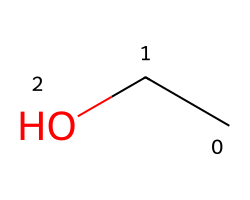

In [232]:
mol = Chem.MolFromSmiles('CCO')
d = rdMolDraw2D.MolDraw2DCairo(250, 200) # or MolDraw2DSVG to get SVGs

d.drawOptions().addStereoAnnotation = True
d.drawOptions().addAtomIndices = True

d.DrawMolecule(mol)
d.FinishDrawing()
d.WriteDrawingText('atom_annotation_2.png') 

display(Image(filename='atom_annotation_2.png'))

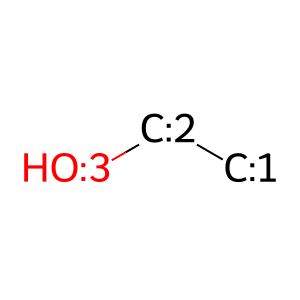

In [233]:
# An other method to have the index on the image

mol = Chem.MolFromSmiles('CCO')

# Add the atom indices to the molecule
for atom in mol.GetAtoms():
    # Add the atom index as a property
    atom.SetProp('molAtomMapNumber', str(atom.GetIdx() + 1))

img_path = 'mol_image.png'
Draw.MolToFile(mol, img_path)

display(Image(filename=img_path))

# Test the fingerprint on one molecule

Index of the molecule: 0
Fingerprint: ('C40H66O5', 'C40O5', 0, 28, [])
ID: LMFA00000001
Common name: 2-methoxy-12-methyloctadec-17-en-5-ynoyl anhydride
Formula: C40H66O5
Number of atoms: 45
Mass: 626.491025


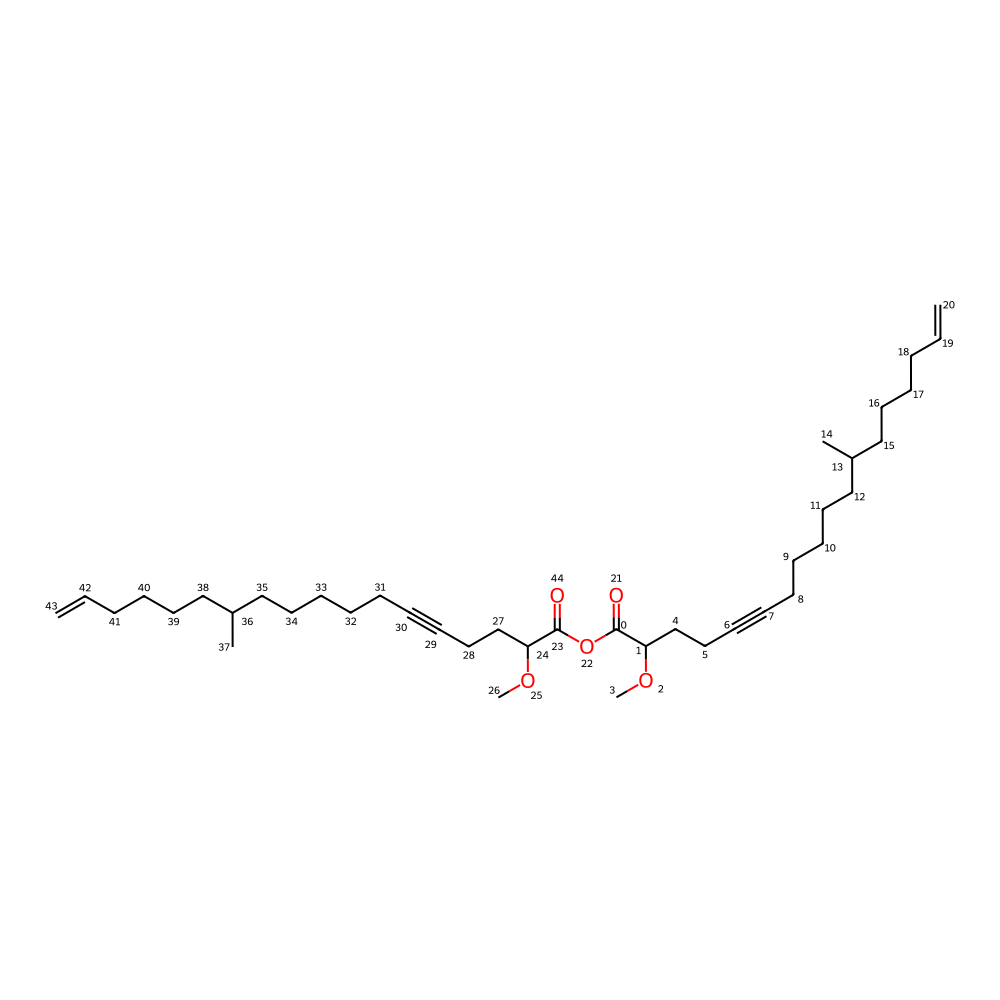

------------------------------
Index of the molecule: 0
Fingerprint: ('C44H84NO8P', 'C44NO8P', 0, 40, ['DOPC'])
ID: LMGP01010890
Common name: PC(18:1(9Z)/18:1(9Z))
Formula: C44H84NO8P
Number of atoms: 54
Mass: 785.593457


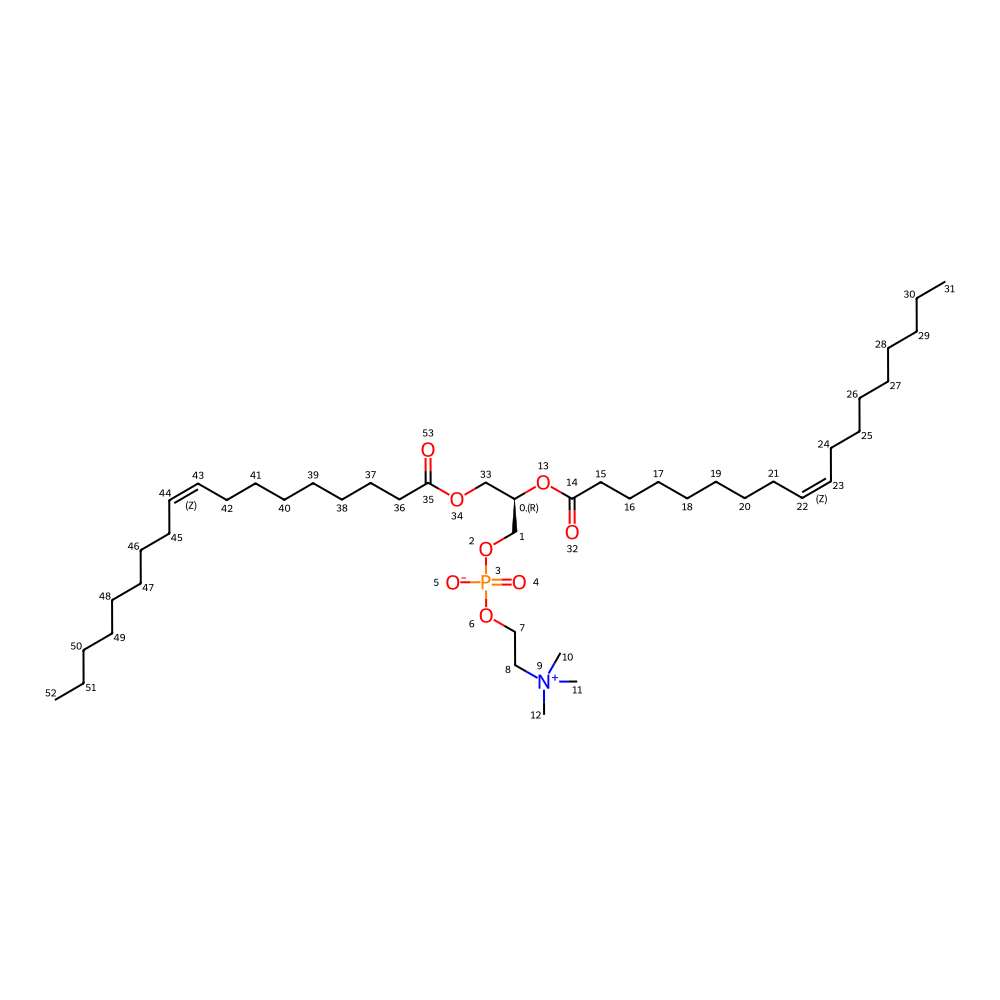

------------------------------


In [234]:
get_info_one_file(fileSDF)
get_info_one_file(fileSDF2)

# Now apply the fingerprint on all the lipidmap database 

In [235]:
# Read the file SDF
supplAll = Chem.SDMolSupplier(fileSDF_all)

# Extract all molecule from the filepath fileSDFAll
ms = [x for x in supplAll if x is not None]

[19:11:04] Warning: conflicting stereochemistry at atom 49 ignored by rule 1a.
[19:11:04] Warning: conflicting stereochemistry at atom 52 ignored by rule 1a.
[19:11:04] Warning: conflicting stereochemistry at atom 49 ignored by rule 1a.
[19:11:04] Warning: conflicting stereochemistry at atom 52 ignored by rule 1a.
[19:11:04] Warning: conflicting stereochemistry at atom 77 ignored by rule 1a.
[19:11:04] Warning: conflicting stereochemistry at atom 77 ignored by rule 1a.
[19:11:04] Warning: conflicting stereochemistry at atom 81 ignored by rule 1a.
[19:11:04] Warning: conflicting stereochemistry at atom 81 ignored by rule 1a.
[19:11:08] Warning: conflicting stereochemistry at atom 56 ignored by rule 1a.
[19:11:08] Warning: conflicting stereochemistry at atom 56 ignored by rule 1a.


In [236]:
# type : list[rdkit.Chem.rdchem.Mol]
sorted_lipid = sorted(ms, key=get_fingerprint)

In [237]:
print(len(sorted_lipid))  # 47974
print(48475 - len(sorted_lipid)) # have 501 molecules missing

# 48475 is the number listed on their page : https://www.lipidmaps.org/databases/lmsd/overview 

47974
501


In [238]:
# Here I want to know if the 501 molecules missing 
# are because it go in the else 
# or because it's not in the file

mol_index_ok, mol_index_none = 0, 0
for mol in supplAll:
    mol_index_ok += 1 if mol is not None else 0
    mol_index_none += 1 if mol is None else 0

print(mol_index_ok)
print(mol_index_none)

[19:11:33] Warning: conflicting stereochemistry at atom 49 ignored by rule 1a.
[19:11:33] Warning: conflicting stereochemistry at atom 52 ignored by rule 1a.
[19:11:33] Warning: conflicting stereochemistry at atom 49 ignored by rule 1a.
[19:11:33] Warning: conflicting stereochemistry at atom 52 ignored by rule 1a.
[19:11:33] Warning: conflicting stereochemistry at atom 77 ignored by rule 1a.
[19:11:33] Warning: conflicting stereochemistry at atom 77 ignored by rule 1a.
[19:11:33] Warning: conflicting stereochemistry at atom 81 ignored by rule 1a.
[19:11:33] Warning: conflicting stereochemistry at atom 81 ignored by rule 1a.


47974
0


[19:11:37] Warning: conflicting stereochemistry at atom 56 ignored by rule 1a.
[19:11:37] Warning: conflicting stereochemistry at atom 56 ignored by rule 1a.


In [239]:
size_syn_5, size_syn_5_not = 0, 0  # To count the number of lipid that have synonym with more and less than 5 characters
nb_group = 0  # To count how many group there is
BD_lipid = []

for fingerprint, group in groupby(sorted_lipid, key=get_fingerprint):
    # fingerprint {tuple} : (formula with hydrogen and without, nb_aromatic_ring, nb_rotatable_bonds, synonym)
    # group {itertools._grouper} : all object rdkit.Chem.rdchem.Mol that have the same fingerprint
    
    if fingerprint[4]:
        size_group = 0 
        group_list = []  # To collect the molecule's id for each groupe
        for mol in group:
            num_atoms = mol.GetNumAtoms() 
            size_group += 1
            group_list.append(mol.GetProp("LM_ID"))
        
        # To test if there is more than one molecule for each group create with groupby
        if size_group > 1:
            print(fingerprint)
            print(group_list)
        print(fingerprint[4])
        BD_lipid.extend(fingerprint[4])
        size_syn_5 += 1
        print("------------------------")
    else: 
        size_syn_5_not += 1

    nb_group+=1
    

['DHMA']
------------------------
['PAF']
------------------------
['PAF']
------------------------
['PQ-1']
------------------------
['3D5']
------------------------
['5M5']
------------------------
['9M1']
------------------------
['CEHC']
------------------------
['5D5']
------------------------
['LDEA']
------------------------
['PAVA']
------------------------
['5M7']
------------------------
['7M5']
------------------------
['9M3']
------------------------
['HOD']
------------------------
['GLA']
------------------------
['RLnA']
------------------------
['7D5']
------------------------
['9D3']
------------------------
['DODA', 'FIF']
------------------------
['(S)-']
------------------------
['POEA']
------------------------
['PAF']
------------------------
['GA29']
------------------------
['8D5']
------------------------
['9D4']
------------------------
['11M3']
------------------------
['9M5']
------------------------
['GA19']
------------------------
['GA17']
---------------

In [240]:
print(f"{size_syn_5} lipids that have a synonym with less than 5 characters")
print(f"{size_syn_5_not} lipids that have a synonym with more than 5 caracters or don't have one")
print(f"{nb_group} group have been detected by the fingerprint")

175 lipids that have a synonym with less than 5 characters
14165 lipids that have a synonym with more than 5 caracters or don't have one
14340 group have been detected by the fingerprint


In [241]:
# Here is all the synonym that have less than 5 caracters
# That we going to use and compare it with the resname in a GRO or PDB file
print(BD_lipid)

['DHMA', 'PAF', 'PAF', 'PQ-1', '3D5', '5M5', '9M1', 'CEHC', '5D5', 'LDEA', 'PAVA', '5M7', '7M5', '9M3', 'HOD', 'GLA', 'RLnA', '7D5', '9D3', 'DODA', 'FIF', '(S)-', 'POEA', 'PAF', 'GA29', '8D5', '9D4', '11M3', '9M5', 'GA19', 'GA17', 'GA28', 'EXA4', 'RvE4', 'AA', '12S-', 'HXA3', 'HXB3', 'LXA4', 'LXB4', '11D3', '9D5', 'EEA', 'OEA', 'VEA', 'tVEA', 'PAF', 'THC', 'CBD', 'THS', '10D5', '11D4', '11M5', '2-LG', '2OG', 'LPA', 'LOL', 'PAF', 'Mar1', 'Mar2', 'NPD1', 'PD1', 'PDX', 'RvD5', 'RvD6', 'RvD1', 'RvD2', 'RvD3', 'RvD4', 'AEA', 'RvT4', 'RvT1', 'RvT2', 'RvT3', 'AEA', 'ETEA', 'JEA', 'NAT', 'PMI2', 'PMD2', 'PME2', '13D3', 'SEA', 'PAF', '2-AG', 'EXE4', 'LXE4', '1-JG', '2-AG', '2-JG', 'PMH2', '13M5', '2-SG', 'DEA', 'LCA', 'CDCA', 'DCA', 'EDCA', 'HDCA', 'MDCA', 'UDCA', 'ACA', 'CA', 'HCA', 'UCA', '13D5', '15D3', 'PPCS', 'PAF', 'EXD4', 'LXD4', '15M5', 'PAF', 'THEA', 'OLDA', 'GLCA', 'GDCA', 'GCA', 'GHCA', 'TLCA', 'TCA', 'THCA', '15D5', 'PAF', 'PAF', 'PAF', 'PAF', 'NADA', 'NAVA', 'DHT2', 'PAF', 'PAF', '

In [242]:
# List with all the lipid we have in our molecular system generated with CHARMM-GUI 
lipid_list = ["CHL1", "PGSIT", "SDA", "POPS", "CPU", "POPP2", "DPOP", "LIN", "SLPS", "SOPS", 
              "DGGL", "DYGL", "DPPC", "DOGL", "DOPC", "SLGL", "DEPC", "SOGL", "PU3P", "ACET", 
              ]

# Test which is or is not in the LipidMap DataBase
for lipid in lipid_list:
    print(f"{lipid} is in BD: {lipid in BD_lipid}")

CHL1 is in BD: False
PGSIT is in BD: False
SDA is in BD: False
POPS is in BD: True
CPU is in BD: False
POPP2 is in BD: False
DPOP is in BD: False
LIN is in BD: False
SLPS is in BD: False
SOPS is in BD: False
DGGL is in BD: False
DYGL is in BD: False
DPPC is in BD: True
DOGL is in BD: False
DOPC is in BD: True
SLGL is in BD: False
DEPC is in BD: False
SOGL is in BD: False
PU3P is in BD: False
ACET is in BD: False


# Code to have information on their organization
And extract this information to create atom_pair and graph  
Here I test it on one molecule

In [243]:
supply = Chem.SDMolSupplier(fileSDF)

# Here the bond and the atoms index 
# seems not to match the atom indices given in the function draw_molecule()
for mol in supply:
    if mol is not None:
        for bond in mol.GetBonds():
            # Get the atoms index imply in the bond  
            atom_index1 = bond.GetBeginAtomIdx()
            atom_index2 = bond.GetEndAtomIdx()
            
            # Get information about the bond type
            bond_type = bond.GetBondType()

            # Print informations about the bond
            print(f"Atoms index : {atom_index1} {atom_index2}, Bond type : {bond_type}")

Atoms index : 1 0, Bond type : SINGLE
Atoms index : 0 2, Bond type : DOUBLE
Atoms index : 0 3, Bond type : SINGLE
Atoms index : 3 4, Bond type : SINGLE
Atoms index : 4 5, Bond type : SINGLE
Atoms index : 5 6, Bond type : SINGLE
Atoms index : 6 7, Bond type : TRIPLE
Atoms index : 7 8, Bond type : SINGLE
Atoms index : 8 9, Bond type : SINGLE
Atoms index : 9 10, Bond type : SINGLE
Atoms index : 10 11, Bond type : SINGLE
Atoms index : 11 12, Bond type : SINGLE
Atoms index : 12 13, Bond type : SINGLE
Atoms index : 13 14, Bond type : SINGLE
Atoms index : 14 15, Bond type : SINGLE
Atoms index : 15 16, Bond type : SINGLE
Atoms index : 16 17, Bond type : SINGLE
Atoms index : 17 18, Bond type : SINGLE
Atoms index : 18 19, Bond type : DOUBLE
Atoms index : 13 20, Bond type : SINGLE
Atoms index : 21 22, Bond type : DOUBLE
Atoms index : 21 23, Bond type : SINGLE
Atoms index : 23 24, Bond type : SINGLE
Atoms index : 24 25, Bond type : SINGLE
Atoms index : 25 26, Bond type : SINGLE
Atoms index : 26 27

In [244]:
# https://www.rdkit.org/docs/GettingStartedInPython.html#atom-pairs-and-topological-torsions

# I don't know if I am going to use this code 
# I don't understand it very well despite the documentation
suppl = Chem.SDMolSupplier(fileSDF)
ms = [x for x in suppl if x is not None]

# Create a fingerprint generator based on atom pairs
fpgen = AllChem.GetAtomPairGenerator()

# Generate fingerprints based on atom pairs for each molecule
pairFps = [fpgen.GetSparseCountFingerprint(x) for x in ms]

# Print pairFps : 
    # option 1: --------------------------------------
# Retrieve the fingerprint for the first molecule
fp = pairFps[0]

# Retrieve non-zero elements from fingerprint in dictionary form
nonzero_elements = fp.GetNonzeroElements()

# Print index and values ​​of active bits
for idx, value in nonzero_elements.items():
    print(f"Index: {idx} --- Value: {value} --- {Pairs.ExplainPairScore(idx)})")
    # idx: index of this atom pairs 
    # value: the occurrence of this atom pairs in this molecule
    # Pairs.ExplainPairScore(idx): explain the atom pairs
        # Example of an output: (('C', 1, 0), 8, ('C', 1, 0))
        # It give information about the atom pairs
        # It means there is a carbon with the formal charge 1 and 0 implicit hydrogens
        # And the frequency of occurrence of this pair is 8

    # option 2: --------------------------------------
# pairFps[-1].GetNonzeroElements()



Index: 541736 --- Value: 1 --- (('C', 1, 0), 8, ('C', 1, 0)))
Index: 541741 --- Value: 2 --- (('C', 1, 0), 13, ('C', 1, 0)))
Index: 541745 --- Value: 2 --- (('C', 1, 0), 17, ('C', 1, 0)))
Index: 541754 --- Value: 1 --- (('C', 1, 0), 26, ('C', 1, 0)))
Index: 558114 --- Value: 4 --- (('C', 1, 0), 2, ('C', 2, 0)))
Index: 558115 --- Value: 6 --- (('C', 1, 0), 3, ('C', 2, 0)))
Index: 558116 --- Value: 6 --- (('C', 1, 0), 4, ('C', 2, 0)))
Index: 558117 --- Value: 4 --- (('C', 1, 0), 5, ('C', 2, 0)))
Index: 558118 --- Value: 2 --- (('C', 1, 0), 6, ('C', 2, 0)))
Index: 558119 --- Value: 4 --- (('C', 1, 0), 7, ('C', 2, 0)))
Index: 558120 --- Value: 4 --- (('C', 1, 0), 8, ('C', 2, 0)))
Index: 558121 --- Value: 4 --- (('C', 1, 0), 9, ('C', 2, 0)))
Index: 558122 --- Value: 4 --- (('C', 1, 0), 10, ('C', 2, 0)))
Index: 558123 --- Value: 4 --- (('C', 1, 0), 11, ('C', 2, 0)))
Index: 558124 --- Value: 2 --- (('C', 1, 0), 12, ('C', 2, 0)))
Index: 558125 --- Value: 4 --- (('C', 1, 0), 13, ('C', 2, 0)))
I